# Tropical Cyclones Classification Project


Link to the data: https://www.kaggle.com/datasets/noaa/hurricane-database/data

About the data:

The National Hurricane Center (NHC) conducts a post-storm analysis of each tropical cyclone in the Atlantic
basin (i.e., North Atlantic Ocean, Gulf of Mexico, and Caribbean Sea) and the North Pacific Ocean to determine the official assessment of the cyclone's history. This analysis makes use of all available observations, including those that may not have been available in real time. In addition, NHC conducts ongoing reviews of any retrospective tropical cyclone analyses brought to its attention and on a regular basis updates the historical record to reflect
changes introduced.

Full description of the data can be found here: https://www.nhc.noaa.gov/data/hurdat/hurdat2-format-atlantic.pdf

Goal: Classify the cyclones detected in the atlantic ocean (i.e., determine the type of the cyclone, target class: 'Status')

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from xgboost import XGBClassifier

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Uploading the Dataset

In [5]:
data_atlantic = pd.read_csv('data/atlantic_corrupted.csv')
data_atlantic.head()

,Unnamed: 0,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,0,AL011851,UNNAMED,18510625.0,NaN,,HU,28.0N,94.8W,80.0,...,-999.0,-999.0,-999.0,NaN,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,1,AL011851,UNNAMED,18510625.0,NaN,,HU,28.0N,95.4W,80.0,...,-999.0,-999.0,-999.0,NaN,-999.0,NaN,-999.0,-999.0,-999.0,-999.0
2,2,AL011851,UNNAMED,18510625.0,NaN,,HU,28.0N,96.0W,80.0,...,-999.0,-999.0,-999.0,NaN,-999.0,-999.0,-999.0,-999.0,NaN,-999.0
3,3,AL011851,UNNAMED,18510625.0,1800.0,,HU,28.1N,96.5W,80.0,...,-999.0,-999.0,-999.0,NaN,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4,AL011851,UNNAMED,18510625.0,NaN,L,HU,28.2N,96.8W,80.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [6]:
data_atlantic.shape

(49596, 23)

The dataset consists of over 49 thousand instances and 22 features. We shall now take a closer look to the dataset and do the first preprocessing step.

## First Preprocessing

Here, we must firstly deal with missing data, drop unnecessary features if needed and understand what kind of data we have.

In [7]:
data_atlantic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49596 entries, 0 to 49595
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        49596 non-null  int64  
 1   ID                49105 non-null  object 
 2   Name              49105 non-null  object 
 3   Date              49105 non-null  float64
 4   Time              27008 non-null  float64
 5   Event             49105 non-null  object 
 6   Status            49105 non-null  object 
 7   Latitude          49105 non-null  object 
 8   Longitude         49105 non-null  object 
 9   Maximum Wind      37811 non-null  float64
 10  Minimum Pressure  49105 non-null  float64
 11  Low Wind NE       34374 non-null  float64
 12  Low Wind SE       17187 non-null  float64
 13  Low Wind SW       49105 non-null  float64
 14  Low Wind NW       49105 non-null  float64
 15  Moderate Wind NE  49105 non-null  float64
 16  Moderate Wind SE  6798 non-null   float6

What we have is this:
- 'Unnamed: 0' column is just an ID column generated by data_noiser code, we will remove it.
- 'Event', 'Status', 'Latitude', 'Longitude' are all non numerical features. 
- 'ID' and 'Name' are the same thing, they just identify the certain event.

We shall remove 'Unnamed: 0' column now, since it was generated by data noiser and just indicates the id of samples, which we have in any case.

In [8]:
data_atlantic.set_index('Unnamed: 0', inplace=True)
data_atlantic.shape

(49596, 22)

Now, let's take a closer look and evaluate how much data is missing for each column.

In [9]:
data_atlantic.isnull().sum(axis=0) / data_atlantic.shape[0] * 100 # just for fun, let's see it in 'percentage' 

ID                   0.989999
Name                 0.989999
Date                 0.989999
Time                45.543995
Event                0.989999
Status               0.989999
Latitude             0.989999
Longitude            0.989999
Maximum Wind        23.761997
Minimum Pressure     0.989999
Low Wind NE         30.691991
Low Wind SE         65.345996
Low Wind SW          0.989999
Low Wind NW          0.989999
Moderate Wind NE     0.989999
Moderate Wind SE    86.293249
Moderate Wind SW     0.989999
Moderate Wind NW    18.809985
High Wind NE         0.989999
High Wind SE         0.989999
High Wind SW        34.651988
High Wind NW         0.989999
dtype: float64

What we see is this:
- 'Time', 'Latitude', 'Maximum Wind', 'Low Wind NE', 'Low Wind SE', 'Moderate Wind NW' and 'High Wind SW' have moderately high percentage of missing data.
- The rest of the features have the same percentage of missing data, so we 'suspect' there are samples full of only missing data. Let's check:

In [10]:
# we check on axis=1, i.e. all the rows, for the instances full of only missing data by comparing the sum of missing values to the number of columns
print(f'Amount of samples containing only missing data: {(data_atlantic.isnull().sum(axis=1) == data_atlantic.shape[1]).sum()}')
print(f'The percentage of such rows: {((data_atlantic.isnull().sum(axis=1) == data_atlantic.shape[1]).sum())/data_atlantic.shape[0] * 100}')

Amount of samples containing only missing data: 491
The percentage of such rows: 0.9899991934833454


We have nearly 500 rows with missing data. This is less than 1% of total data, we can remove these rows.

In [11]:
data_atlantic.dropna(how='all', axis=0, inplace=True)
data_atlantic.shape

(49105, 22)

Now we go back to the rest of the missing data

In [12]:
data_atlantic.isnull().sum(axis=0) / data_atlantic.shape[0] * 100  

ID                   0.000000
Name                 0.000000
Date                 0.000000
Time                44.999491
Event                0.000000
Status               0.000000
Latitude             0.000000
Longitude            0.000000
Maximum Wind        22.999695
Minimum Pressure     0.000000
Low Wind NE         29.998982
Low Wind SE         64.999491
Low Wind SW          0.000000
Low Wind NW          0.000000
Moderate Wind NE     0.000000
Moderate Wind SE    86.156196
Moderate Wind SW     0.000000
Moderate Wind NW    17.998167
High Wind NE         0.000000
High Wind SE         0.000000
High Wind SW        33.998574
High Wind NW         0.000000
dtype: float64

- Time has a float value here and missing values shall be substituted by median value.
- Latitude and Longitude here are object, but it can be transformed into numerical features + missing values will be substitued by mean values.
- Maximum Wind, Low Wind NE, Low Wind SE, Moderate Wind NW, High Wind SW, Moderate Wind SE are all numerical features, mean values will be imputed.

Alright, we know what to do with missing values; what shall we do with the rest of the features (i.e., the ones with the type 'object')

- ID and Name are practically the same, one of them will be dropped, the other substituted by integers.
- Latitude and Longitude can be converted to float by using extra function we shall define below
- Status is a categorical feature, and here we can just encode names of classes by mapping them to the integers.

Before we proceed, we take closer look at the 'Status' and 'Event' features.

[' HU' ' TS' ' EX' ' TD' ' LO' ' DB' ' SD' ' SS' ' WV']
3


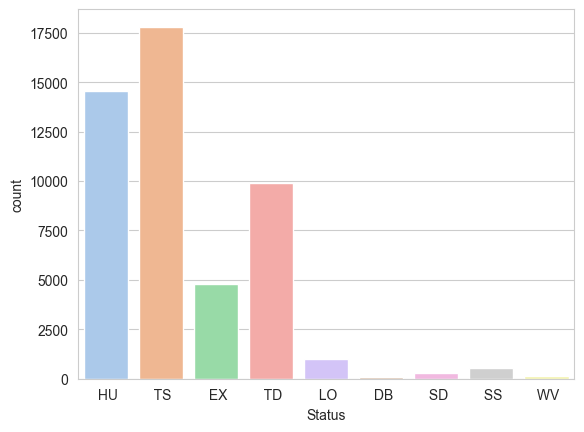

In [13]:
sns.countplot(x='Status', data=data_atlantic, palette='pastel')
print(data_atlantic.Status.unique())
print(len(data_atlantic.Status.unique()[0]))

Status can be the following types:
- TD – Tropical cyclone of tropical depression intensity (< 34 knots)
- TS – Tropical cyclone of tropical storm intensity (34-63 knots)
- HU – Tropical cyclone of hurricane intensity (> 64 knots)
- EX – Extratropical cyclone (of any intensity)
- SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
- SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
- LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
- WV – Tropical Wave (of any intensity)
- DB – Disturbance (of any intensity)

Status is our target class; we shall encode these categories and learn the model to classify the cyclones.

As for the Event, if we take a closer look...

L – Record identifier
C – Closest approach to a coast, not followed by a landfall
G – Genesis
I – An intensity peak in terms of both pressure and wind
L – Landfall (center of system crossing a coastline)
P – Minimum in central pressure
R – Provides additional detail on the intensity of the cyclone when rapid changes are underway
S – Change of status of the system
T – Provides additional detail on the track (position) of the cyclone
W – Maximum sustained wind speed

While these value carry some information, we can easily remove them.

Thus, we shall apply the following transformations:

1. Features representing data bout Wind, Pressure, Time: 
        - SimpleImputer, i.e. substitute missing values with mean of each column
        - StandardScaler, i.e. bring features to the same scale 
2. Latitude, Longitude:
        - CoordinateTransformer: define the new transformer class which takes these features and returns numerical values instead of strings
        - StandardScaler (bring them to the same scale)
3. Event:
        - EventTransformer: define the new transformer class which transforms the categories into numerical features.
4. Date:
        - DateTransformer: define the new transformer to change the format of the dates in the dataset.


The rest shall be dropped.

### Defining extra Transformers

In [14]:
class CoordinateTransformer(BaseEstimator, TransformerMixin):
    """
    The class converts given coordinates into numerical values (float) 
    while preserving the information about the coordinate (N, E, W, S)
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def coordinate_mapping(self, x):
        # if latitude/longitude value has S/W at the end, we indicate it by multiplying the numerical value by -1
        # otherwise, it's normal
        coord = float(x[:-1]) # convert the string into float, except for the last symbol
        if x[-1] in ["W", "S"]:
            coord *= -1
        return coord
    
    def transform(self, X, y=None):
        X = X.copy()
        X["Latitude"] = X["Latitude"].apply(self.coordinate_mapping)
        X["Longitude"] = X["Longitude"].apply(self.coordinate_mapping)
        return X

In [15]:
class EventTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        if mapping is None:
            self.mapping = {
                '  ': 0, ' L': 1, ' C': 2, ' G': 3, ' I': 4, ' R': 5, 
                ' P': 6, ' W': 7, ' S': 8, ' T': 9
            }
        else:
            self.mapping = mapping
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['Event'] = X['Event'].map(self.mapping)
        return X

In [16]:
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    This class converts the format to '%Y%m%d' and then creates 3 new features for storing Year, Month, Day
    """
    def __init__(self, date_format='%Y%m%d'):
        self.date_format = date_format
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        date = pd.to_datetime(X['Date'], format=self.date_format)
        X['Year'] = date.dt.year
        X['Month'] = date.dt.month
        X['Day'] = date.dt.day
        X = X.drop(['Date'], axis=1)
        return X

Now we can create the pipelines and the final column transformer.


In [17]:
pipeline_event = Pipeline([
    ('event_changer', EventTransformer()),
    ('scaler', StandardScaler())
])

pipeline_date = Pipeline([
    ('change_dates', DateTransformer()),
    ('scaler', StandardScaler())
])

pipeline_winds_time = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pipeline_coords = Pipeline([
    ('transform', CoordinateTransformer()),
    ('scaler', StandardScaler())
])


final_transformer = ColumnTransformer([
    ('categories', pipeline_event, ['Event']),
    ('winds_of_change', pipeline_winds_time, ['Time', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']),
    ('coords', pipeline_coords, ['Latitude', 'Longitude']),
    ('dates', pipeline_date, ['Date']),
    #('id_transformer', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'), ['ID'])
],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0)

## Train - Test Split

Now we are splitting the data into train and test sets. 
As we said before, 'Status' is our target, y.

In [18]:
X = data_atlantic.drop(['Status'], axis=1)
y = data_atlantic['Status']
y = y.map({' HU': 1, ' TS': 2, ' EX': 3, ' TD': 4, ' LO': 5, ' DB': 6, ' SD': 7, ' SS': 8, ' WV': 9})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=43, 
                                                    stratify=y, 
                                                    shuffle=True)

## Model Selection

In [19]:
model_pipeline = IMBPipeline([ # each element in a Pipeline is mainly a step related to a different technique 
    ('transformer', final_transformer),  # transformation
    ('sampler', SMOTE()), # another transformer;
    ('dim_reduction', PCA(n_components=0.8)), # dimensionality reduction, if we want
    ('classifier', Perceptron()) # classifier, of course - there is a placeholder Perceptron, BUT it can be subsittuted with other model
])

In [20]:
model_pipeline.fit(X_train, y_train) # just a check that al the elements are correctly defined; can be omitted

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categories',
                                                  Pipeline(steps=[('event_changer',
                                                                   EventTransformer(mapping={'  ': 0,
                                                                                             ' C': 2,
                                                                                             ' G': 3,
                                                                                             ' I': 4,
                                                                                             ' L': 1,
                                                                                             ' P': 6,
                                                                                             ' R': 5,
                                                                                             ' S': 8,
                                                                                             ' T': 9,
                                                                                             ' W': 7})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Event']),
                                                 ('winds_of_change',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['T...
                                                   'High Wind NW']),
                                                 ('coords',
                                                  Pipeline(steps=[('transform',
                                                                   CoordinateTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude']),
                                                 ('dates',
                                                  Pipeline(steps=[('change_dates',
                                                                   DateTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Date'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [21]:
# the reason hyperparameters are called like this is because without specification (sampler, dim_reduction, etc.) we may have the case of two hyperparameters with the same name in different 'boxes' and the program will crash

sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[RandomUnderSampler()],
        'sampler__sampling_strategy':['majority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.8]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1_weighted', forward=False)], # sequential Backward Selection
        'dim_reduction__estimator': [LogisticRegression(random_state=42, solver='saga')],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [5, 7, 9, 11]
    },
    {
        'classifier' : [RandomForestClassifier(bootstrap=True)],
        'classifier__n_estimators' : [50, 100, 500, 700],
        'classifier__max_depth': [4, 6, 8, 10],
        'classifier__criterion': ['gini', 'entropy', 'log_loss']
    },
    {
        'classifier': [OneVsRestClassifier(estimator=Perceptron())],
        'classifier__estimator': [{
            'classifier': LogisticRegression(solver='saga', random_state=42),
            'classifier__C': loguniform(0.001, 100),
            'classifier__penalty': ['l1', 'l2'],
            'classifier__class_weight': ['balanced', None]
        }]
    },
    {
        'classifier': [XGBClassifier()],
        'classifier__n_estimators' : [100, 250, 500, 1000],
        'classifier__learning_rate' : [0.001, 0.05, 0.01, 0.1],
        'classifier__max_depth' : [6, 8, 10]
    }
]

In [22]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [23]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 36'

In [24]:
rs = RandomizedSearchCV(model_pipeline,
                        param_distributions=all_configs,
                        n_iter=len(all_configs)*5,
                        n_jobs=-1,
                        cv=2, 
                        scoring='f1_weighted')

In [25]:
scores = cross_validate(rs, X_train, y_train, scoring='f1_weighted', 
                        cv=5, 
                        return_estimator=True, 
                        verbose=3) 

[CV] END ......................................., score=0.710 total time=13.4min
[CV] END ......................................., score=0.842 total time=11.5min
[CV] END ......................................., score=0.781 total time=13.4min
[CV] END ......................................., score=0.838 total time=13.4min
[CV] END ......................................., score=0.835 total time=24.9min


In [26]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
KNeighborsClassifier(n_neighbors=9) {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
0.7103271496844538
----------
None
None
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8424115509130208
----------
RandomOverSampler(sampling_strategy='minority')
None
RandomForestClassifier(criterion='log_loss', max_depth=6, n_estimators=700) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 6, 'max_feature

So, for now the best model is this one: 
None
SequentialFeatureSelector(cv=None, estimator=RandomForestClassifier(),
                          forward=False, k_features=(10, 10),
                          scoring='f1_weighted')
RandomForestClassifier(criterion='entropy', max_depth=10) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [27]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'Estimator:{estimator.best_estimator_.get_params()['classifier']}, F1 on training set:{f1_train}, F1 on test set:{f1_test}')

Estimator:KNeighborsClassifier(n_neighbors=9), F1 on training set:0.7802917875546899, F1 on test set:0.7202972192759333
Estimator:RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500), F1 on training set:0.8599349774530808, F1 on test set:0.841218736514251
Estimator:RandomForestClassifier(criterion='log_loss', max_depth=6, n_estimators=700), F1 on training set:0.7835925389718227, F1 on test set:0.7800258458784624
Estimator:RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=700), F1 on training set:0.859124996798428, F1 on test set:0.8398658327998558
Estimator:RandomForestClassifier(criterion='entropy', max_depth=10), F1 on training set:0.8576436052213544, F1 on test set:0.8378486671350752


The first model performs better on the test set than all the others, so we make a final pick: Estimator:RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500)

## Refinement of the Selected Model


In [28]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformer),
    ('classifier',RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500))
])

params = {
    'classifier__max_depth': [8, 10, 12], 
    'classifier__criterion': ['gini', 'entropy']
}

In [29]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions=params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=10,
    scoring='f1_weighted'
)

In [30]:
rs_best.fit(X_train, y_train) # 20 min

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('categories',
                                                                               Pipeline(steps=[('event_changer',
                                                                                                EventTransformer(mapping={'  ': 0,
                                                                                                                          ' C': 2,
                                                                                                                          ' G': 3,
                                                                                                                          ' I': 4,
                                                                                                                          ' L': 1,
                                                                                                                          ' P': 6,
                                                                                                                          ' R': 5,
                                                                                                                          ' S': 8,
                                                                                                                          ' T': 9,
                                                                                                                          ' W': 7})),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Event']),...
                                                                                'Longitude']),
                                                                              ('dates',
                                                                               Pipeline(steps=[('change_dates',
                                                                                                DateTransformer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Date'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              RandomForestClassifier(criterion='entropy',
                                                                     max_depth=10,
                                                                     n_estimators=500))]),
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': [8, 10, 12]},
                   scoring='f1_weighted')

In [31]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categories',
                                                  Pipeline(steps=[('event_changer',
                                                                   EventTransformer(mapping={'  ': 0,
                                                                                             ' C': 2,
                                                                                             ' G': 3,
                                                                                             ' I': 4,
                                                                                             ' L': 1,
                                                                                             ' P': 6,
                                                                                             ' R': 5,
                                                                                             ' S': 8,
                                                                                             ' T': 9,
                                                                                             ' W': 7})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Event']),
                                                 ('winds_of_change',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Time', '...
                                                   'High Wind NW']),
                                                 ('coords',
                                                  Pipeline(steps=[('transform',
                                                                   CoordinateTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude']),
                                                 ('dates',
                                                  Pipeline(steps=[('change_dates',
                                                                   DateTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Date'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=12,
                                        n_estimators=500))])

In [32]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test), average='weighted')

np.float64(0.8562349591921901)

In [33]:
cls = rs_best.best_estimator_

In [34]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                        cv=5, 
                                                        n_jobs=-1,
                                                        scoring='f1_weighted',
                                                        shuffle=False)

(0.6, 1.03)

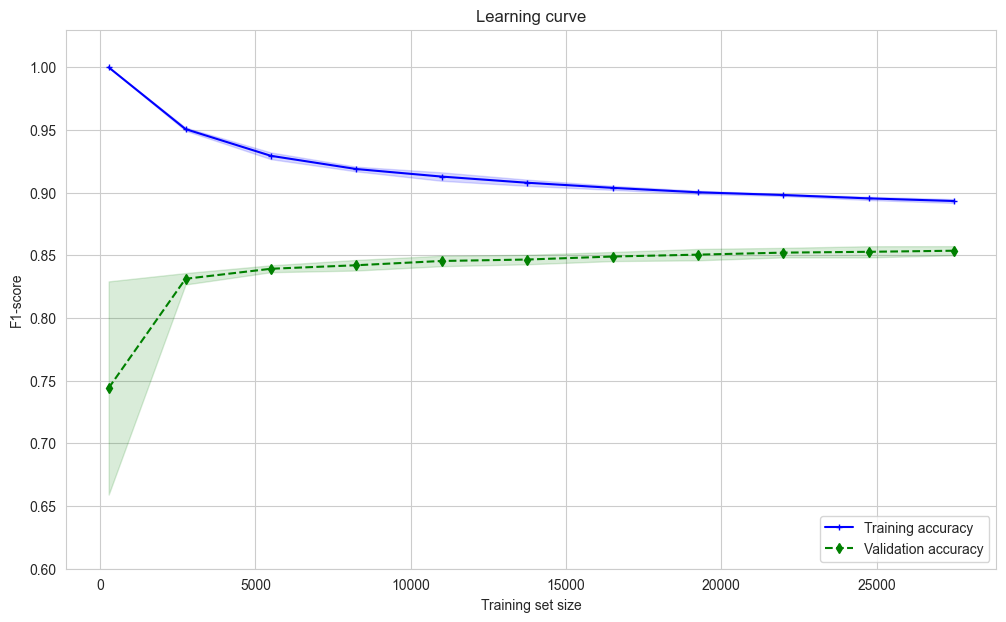

In [35]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_title('Learning curve')
ax.set_ylim([0.60, 1.03])

In [36]:
range_max_depth = [8, 10, 12, 14]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_max_depth, 
        param_name='classifier__max_depth',
        cv=5, 
        n_jobs=-1, 
        scoring='f1_weighted'
)

(6.0, 15.0)

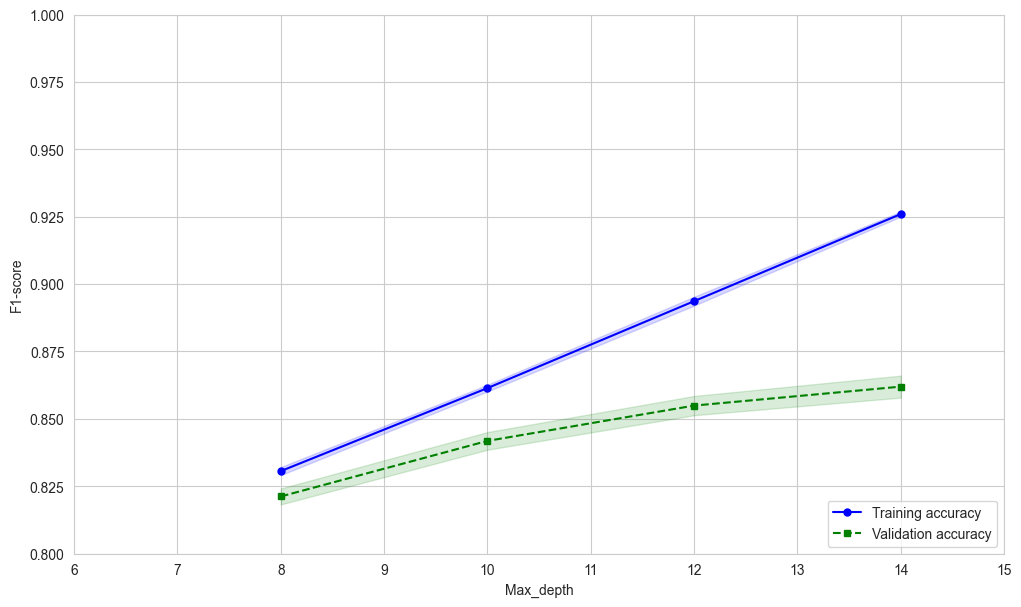

In [37]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_max_depth, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_max_depth,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_max_depth, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_max_depth,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.set_xlabel('Max_depth')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.8, 1.0])
ax.set_xlim([6, 15])